<a href="https://colab.research.google.com/github/Permanganant/AI-in-Medicine-I/blob/main/Chest_and_breast_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pratical excersice 1: Chest and breast classification

Before you start to solve the exercise, please write your TUM-IDs alongside the names of all group members. This will enable us to assign grades accurately. Thank you.

Member 1: Mert Alperen Beser 03781570

Member 2: Bilgehan Demir 03781023

Member 3: Eylül Kepcen 03780122

In [ ]:
!pip install medmnist

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, auc
from matplotlib import pyplot as plt

import medmnist
from medmnist import INFO

## Task 1: 2D breast ultrasound classification.

## Dataloading
We first load a 2D dataset breast ultrasound dataset-BreastMNIST, preprocess it and encapsulate it into dataloader form. Please fill the empty blanks in the following bloacks. You are expected to show the details of training, validation, and test dataset.

In [ ]:
data_flag_2d = 'breastmnist' # here the name of dataset should be passed.
download = True

info = INFO[data_flag_2d] # INFO is embedded in the medmnist containing basic information of datasets
print(info)
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

{'python_class': 'BreastMNIST', 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.', 'url': 'https://zenodo.org/record/6496656/files/breastmnist.npz?download=1', 'MD5': '750601b1f35ba3300ea97c75c52ff8f6', 'task': 'binary-class', 'label': {'0': 'malignant', '1': 'normal, benign'}, 'n_channels': 1, 'n_samples': {'train': 546, 'val': 78, 'test': 156}, 'license': 'CC BY 4.0'}


In [ ]:
"""
Here goes with the hyperparameters for your model.
"""
# hyperparameters
BATCH_SIZE = 128
EPOCH_NUM = 100
lr = 0.01
DataClass = getattr(medmnist, info['python_class']) #?

In [ ]:
"""
Please generate datasets and dataloaders for training, validation, and test dataset.
Datasets should be an object of DataClass and dataloaders should be an object of torch.utils.data.DataLoader.
"""

# preprocessing such as conversion to tensor and normalization
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# get the data class
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)


# encapsulate datasets into Dataloader form
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


Using downloaded and verified file: /Users/mertbeser/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/mertbeser/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/mertbeser/.medmnist/breastmnist.npz


Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /Users/mertbeser/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 78
    Root location: /Users/mertbeser/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'

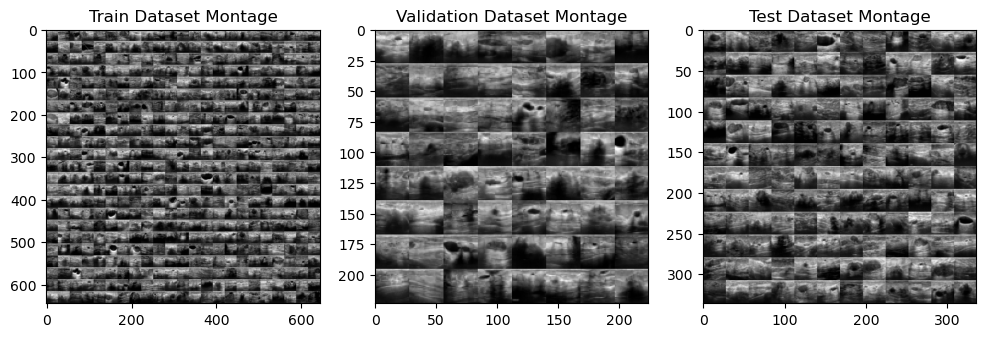

In [ ]:
"""
This block shows the details of the datasets you generated above.
"""
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(train_dataset.montage(length=23), cmap='gray')
plt.title('Train Dataset Montage')

plt.subplot(132)
plt.imshow(val_dataset.montage(length=8), cmap='gray')
plt.title('Validation Dataset Montage')

plt.subplot(133)
plt.imshow(test_dataset.montage(length=12), cmap='gray')
plt.title('Test Dataset Montage')

plt.show()

Please fill the blanks in the following block to show the image and its corresponding class label of 2 subjects:
1. the 50th subject in training dataset
2. the 20th subject in test dataset


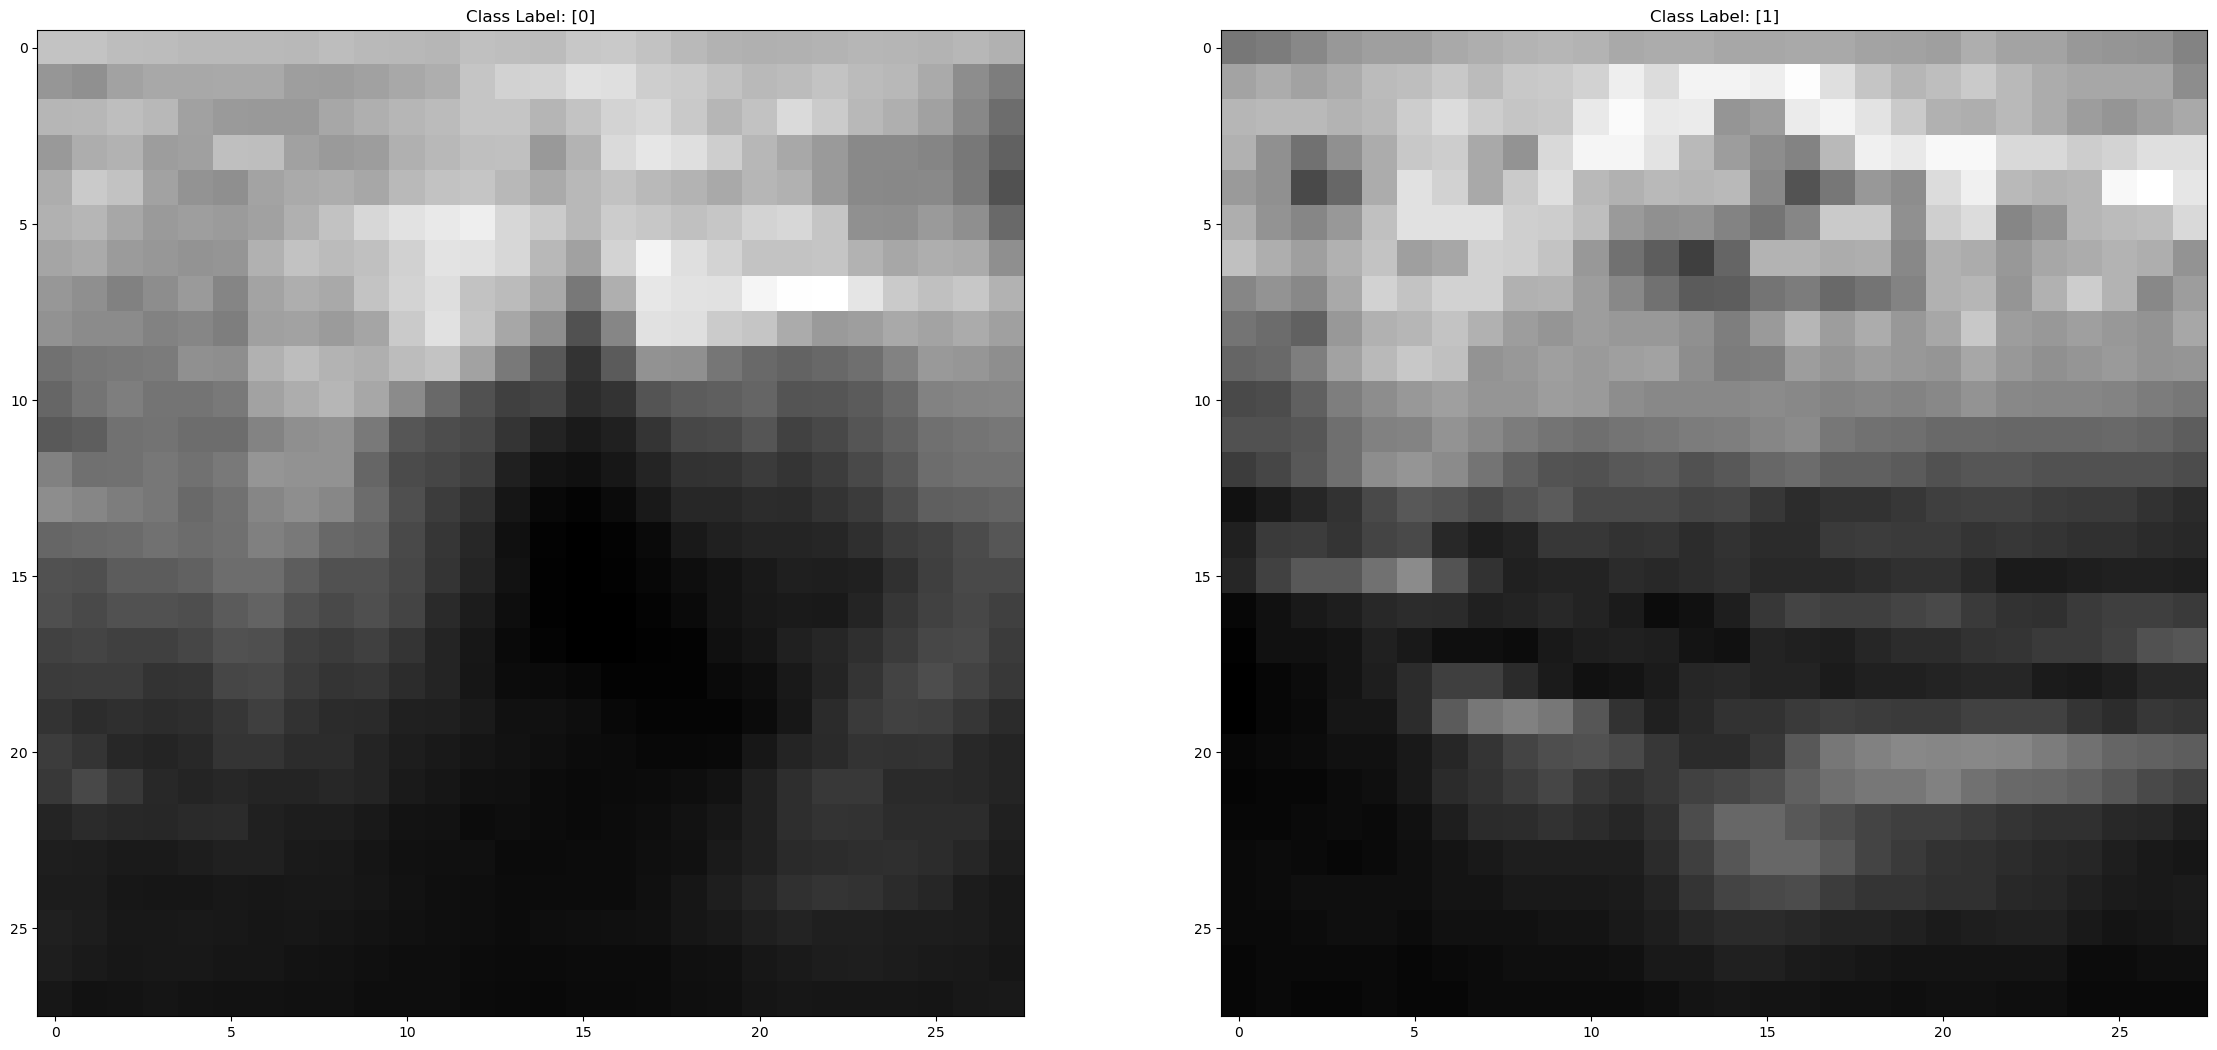

In [ ]:
"""
Please query images and labels and visualize both images with labels as title.
"""
# query images and corresponding labels
im_1, label_1 = train_dataset[49]
im_2, label_2 = test_dataset[19]

#print(im_1)
plt.figure(figsize=(28, 28))
plt.subplot(1, 2, 1)
plt.imshow(im_1[0], cmap='gray')
plt.title(f"Class Label: {label_1}")

plt.subplot(1, 2, 2)
plt.imshow(im_2[0], cmap='gray')
plt.title(f"Class Label: {label_2}")

plt.show()



## Upsampling and downsampling
Upsample the aforementioned subjects with bilinear algorithm from 28$\times$28 to 56$\times$56 and apply a 2D max pooling over the same subjects with kernel size equals 2 and stride equals 2.

**You are expected to use classes implemented in torch.nn.**
*Hit: Pay attention to the dimension of inputs.*


In [ ]:
"""
Please realize upsampling and pooling of target images.
Visualize them with 2*2 subplots and print the size of images.

"""
# upsampling
upsampled_im_1 = im_1.unsqueeze(0)
upsampled_tensor_1 = F.interpolate(upsampled_im_1, scale_factor=2, mode='bilinear', align_corners=False)
print(upsampled_tensor_1.shape)  # Should be (1, 1, 56, 56)
upsampled_im_2 = im_2.unsqueeze(0)
upsampled_tensor_2 = F.interpolate(upsampled_im_2, scale_factor=2, mode='bilinear', align_corners=False)
print(upsampled_tensor_2.shape)  # Should be (1, 1, 56, 56)

# downsampling
m = nn.MaxPool2d(2, stride=2)
pooled_im_1 = m(im_1)
print(pooled_im_1.shape)
pooled_im_2 = m(im_2)
print(pooled_im_2.shape)


torch.Size([1, 1, 56, 56])
torch.Size([1, 1, 56, 56])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])


The size of resulted images: (torch.Size([1, 1, 56, 56]), torch.Size([1, 1, 56, 56]), torch.Size([1, 14, 14]), torch.Size([1, 14, 14])).


<Figure size 640x480 with 0 Axes>

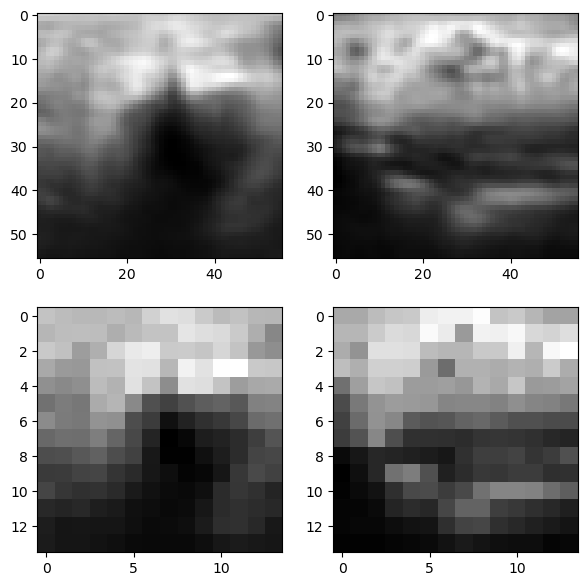

In [ ]:
# visualization
plt.figure()
f, axarr = plt.subplots(2, 2, figsize=(7, 7))

print(f'The size of resulted images: {upsampled_tensor_1.shape, upsampled_tensor_2.shape, pooled_im_1.shape, pooled_im_2.shape}.')
axarr[0, 0].imshow(upsampled_tensor_1[0][0], cmap = 'gray')
axarr[0, 1].imshow(upsampled_tensor_2[0][0], cmap = 'gray')
axarr[1, 0].imshow(pooled_im_1[0], cmap = 'gray')
axarr[1, 1].imshow(pooled_im_2[0], cmap = 'gray')


## Model implementation

Here you should implement a basic CNN model with 5 convolutional layers. The output layer should be two linear layers. The output activation is sigmoid function.

Define a loss criterion that measures the Binary Cross Entropy between the target and the input probabilities with mean reduction.

In [ ]:
"""
Please design a CNN model. You are execpted to invole batch normalization and pooling.
"""

# define the architecture of the model
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
        )


        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3),
            nn.BatchNorm2d(32),
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            )

        self.fc = nn.Sequential(
            nn.Linear(16 * 4 * 4, 16),
            nn.Dropout(0.3),
            nn.Sigmoid(),
            nn.Linear(16, 8),
            nn.Dropout(0.5),
            nn.Sigmoid(),
            nn.Linear(8,1),
            )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# initialize your model
cnn_model = CNN(in_channels=n_channels, num_classes=n_classes)

# define the BCE loss function and an optimizer you prefer
criterion =nn.BCEWithLogitsLoss(reduction='mean')

In [ ]:
!pip install torchsummary

Here shows the summary of designed CNN architecture.

In [ ]:
"""
Here shows the summary of the model you designed with input size of your data and batch size you chose.
Please pass the size of data size to SAMPLE_DATASIZE.
"""
from torchsummary import summary
SAMPLE_DATASIZE = (1, 28, 28)
summary(cnn_model, SAMPLE_DATASIZE, BATCH_SIZE)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 26, 26]             160
       BatchNorm2d-2          [128, 16, 26, 26]              32
            Conv2d-3         [128, 128, 24, 24]          18,560
       BatchNorm2d-4         [128, 128, 24, 24]             256
         MaxPool2d-5         [128, 128, 12, 12]               0
            Conv2d-6          [128, 64, 10, 10]          73,792
       BatchNorm2d-7          [128, 64, 10, 10]             128
            Conv2d-8            [128, 32, 8, 8]          18,464
       BatchNorm2d-9            [128, 32, 8, 8]              64
           Conv2d-10            [128, 16, 8, 8]           4,624
      BatchNorm2d-11            [128, 16, 8, 8]              32
        MaxPool2d-12            [128, 16, 4, 4]               0
           Linear-13                  [128, 16]           4,112
          Dropout-14                  [

## Training and evaluation

Please fill the blanks in train and test functions.

In [ ]:
"""
Please define functions for training and testing.
- train:
    input: dataloader, model
    output: loss_values for training and validation which is a list containing losses for all epochs.
            trained_model
- test:
    input: dataloader, model
    output: auc, acc
    Please also plot the test ROC curve for each class.
"""

def train(train_loader,val_loader, model, num_epochs, learning_rate,criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.to(torch.float32)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum = 0.9)

    loss_values = []
    val_loss_values = []
    epoch_loss = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float()

            #forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            #backward pass
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)

        # Validation loss (you should have a validation dataset and loader)
        model.eval()
        val_loss = 0.0


            # Print your results every epoch

        if total_loss / 1 < 0.000001:
                break

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_labels = val_labels.float()
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_values.append(avg_val_loss)

        print('Epoch: [% d/% d], Training Loss: %.4f, Validation Loss: %.4f'
                  % (epoch + 1, num_epochs, avg_loss,avg_val_loss))

    return loss_values, val_loss_values, model

def test(test_loader, model):
    model.eval()
    test_accuracy = 0.0
    test_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            predictions = model(inputs)
            predicted_classes = (predictions > 0.5).float()
            test_accuracy += (predicted_classes == targets.view(-1, 1)).float().mean()

            all_predictions.append(predictions.cpu().numpy())
            test_targets.extend(targets.view(-1, 1).cpu().numpy())

    test_accuracy /= len(test_loader)
    print(f'Test Accuracy: {test_accuracy.item():.4f}')

    all_predictions = np.vstack(all_predictions)
    test_targets = np.vstack(test_targets)

    # Calculate ROC curve for binary classification
    fpr, tpr, _ = roc_curve(test_targets, all_predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for binary classification
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc, test_accuracy


Epoch: [ 1/ 100], Training Loss: 0.8033, Validation Loss: 0.7756
Epoch: [ 2/ 100], Training Loss: 0.7468, Validation Loss: 0.7032
Epoch: [ 3/ 100], Training Loss: 0.6767, Validation Loss: 0.6440
Epoch: [ 4/ 100], Training Loss: 0.6188, Validation Loss: 0.6063
Epoch: [ 5/ 100], Training Loss: 0.5845, Validation Loss: 0.5875
Epoch: [ 6/ 100], Training Loss: 0.5876, Validation Loss: 0.5810
Epoch: [ 7/ 100], Training Loss: 0.5819, Validation Loss: 0.5796
Epoch: [ 8/ 100], Training Loss: 0.5656, Validation Loss: 0.5792
Epoch: [ 9/ 100], Training Loss: 0.5746, Validation Loss: 0.5786
Epoch: [ 10/ 100], Training Loss: 0.5575, Validation Loss: 0.5775
Epoch: [ 11/ 100], Training Loss: 0.5842, Validation Loss: 0.5765
Epoch: [ 12/ 100], Training Loss: 0.5952, Validation Loss: 0.5750
Epoch: [ 13/ 100], Training Loss: 0.5743, Validation Loss: 0.5734
Epoch: [ 14/ 100], Training Loss: 0.5831, Validation Loss: 0.5721
Epoch: [ 15/ 100], Training Loss: 0.5596, Validation Loss: 0.5710
Epoch: [ 16/ 100], 

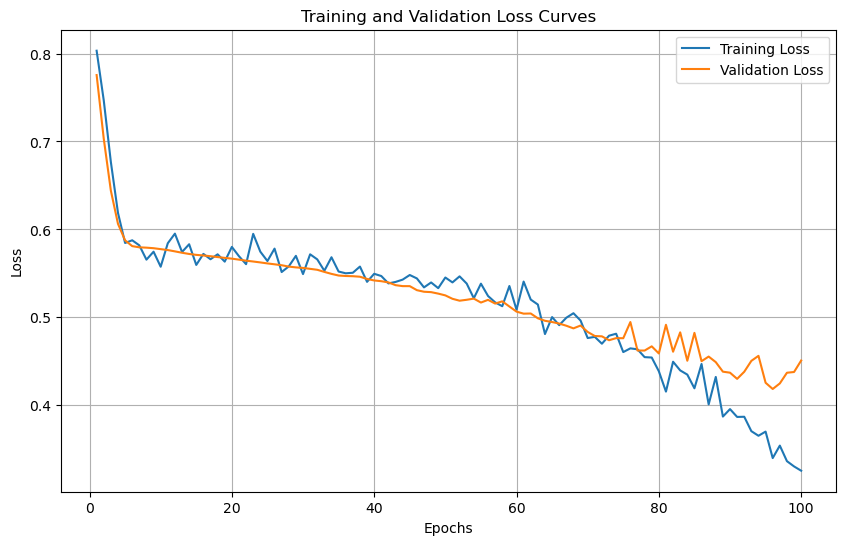

Test Accuracy: 0.8141


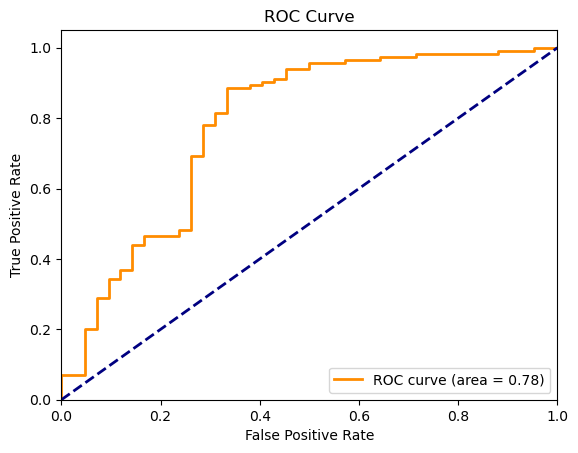

auc: 0.782, acc: 0.814


In [ ]:
"""
Here shows the training and validation curves. AUC and ACC of test will also be printed.
"""
# train
loss_values, val_loss_values, model = train(train_loader,val_loader, cnn_model, EPOCH_NUM, lr, criterion=criterion)

# show training and validation curves
def plot_loss_curves(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage:
plot_loss_curves(loss_values, val_loss_values)

# test
auc_value, acc = test(test_loader, model)
print(f'auc: {round(float(auc_value), 3)}, acc: {round(float(acc), 3)}')


# 3D dataset NoduleMNIST3D

Please fill the blanks in the following block to create dataloaders for training, validation, and test on 3D dataset. The visualization of each dataset is expected.

{'python_class': 'NoduleMNIST3D', 'description': 'The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.', 'url': 'https://zenodo.org/record/6496656/files/nodulemnist3d.npz?download=1', 'MD5': '8755a7e9e05a4d9ce80a24c3e7a256f3', 'task': 'binary-class', 'label': {'0': 'benign', '1': 'malignant'}, 'n_channels': 1, 'n_samples': {'train': 1158, 'val': 165, 'test': 310}, 'license': 'CC BY 4.0'}
Using downloaded and verified file: /Users/mertbeser/.medmnist/nodulemnist3d.np

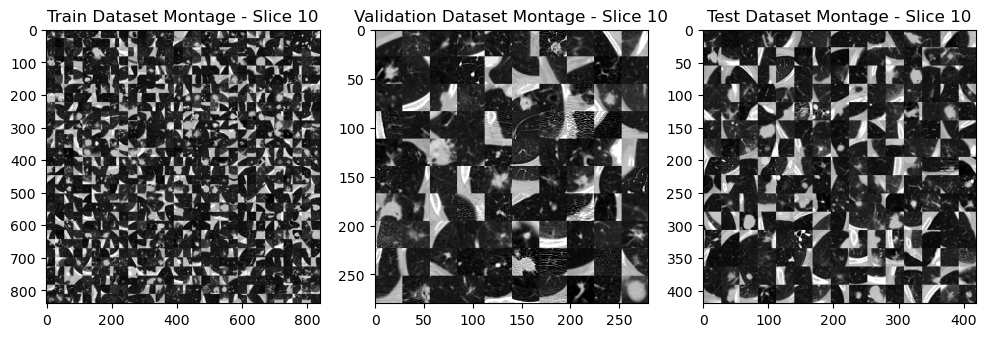

In [ ]:
# hyparameters
BATCH_SIZE = 128
EPOCH_NUM = 12
lr = 0.001

# dataset
data_flag_3d = 'nodulemnist3d' # here the name of dataset should be passed.
download = True

info = INFO[data_flag_3d]
print(info)
task = info['task']

n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# get the data class without transform
train_dataset = DataClass(split='train',  download=download)
test_dataset = DataClass(split='test',  download=download)
val_dataset = DataClass(split='val',  download=download)

# encapsulate datasets into Dataloader form
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# show the details
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

slice_index = 10

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(train_dataset.montage(length=30)[slice_index], cmap='gray')
plt.title(f'Train Dataset Montage - Slice {slice_index}')

plt.subplot(132)
plt.imshow(val_dataset.montage(length=10)[slice_index], cmap='gray')
plt.title(f'Validation Dataset Montage - Slice {slice_index}')

plt.subplot(133)
plt.imshow(test_dataset.montage(length=15)[slice_index], cmap='gray')
plt.title(f'Test Dataset Montage - Slice {slice_index}')

plt.show()

## 3D CNN implementation

Similar to what you have completed, please fill the blanks in following methods.

You expected to design a 3D CNN with 5 layers along with batch normalization and pooling.

In [ ]:
class CNN_3D(nn.Module):
    def __init__(self, in_channels, num_classes):

        super(CNN_3D, self).__init__()
        self.conv_layer1 = self._conv_layer_set(in_channels, 128)
        self.conv_layer2 = self._conv_layer_set(128, 64)
        self.conv_layer3 = self._conv_layer_set(64, 32)
        self.conv_layer4 = self._conv_layer_set(32, 8)
        self.conv_layer5 = self._conv_layer_set(8, 8)
        self.fc1 = nn.Linear(2**3*8, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.LeakyReLU()
        self.batch=nn.BatchNorm1d(32)
        self.drop=nn.Dropout(p=0.5)

    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(1, 1, 1), padding=1),
        nn.LeakyReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer


    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.batch(x)
        x = self.drop(x)
        x = self.fc2(x)

        return x

In [ ]:
# initialize the 3D model
cnn3d_model = CNN_3D(in_channels=1, num_classes=n_classes)

# define the BCE loss function and an optimizer you prefer
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.SGD(cnn3d_model.parameters(), lr=lr,momentum = 0.9)

# show the details
from torchsummary import summary
SAMPLE_DATASIZE =  (1,28, 28,28)
summary(cnn3d_model, SAMPLE_DATASIZE, BATCH_SIZE)

cnn3d_model = cnn3d_model.double()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [128, 128, 30, 30, 30]             256
         LeakyReLU-2     [128, 128, 30, 30, 30]               0
         MaxPool3d-3     [128, 128, 15, 15, 15]               0
            Conv3d-4      [128, 64, 17, 17, 17]           8,256
         LeakyReLU-5      [128, 64, 17, 17, 17]               0
         MaxPool3d-6         [128, 64, 8, 8, 8]               0
            Conv3d-7      [128, 32, 10, 10, 10]           2,080
         LeakyReLU-8      [128, 32, 10, 10, 10]               0
         MaxPool3d-9         [128, 32, 5, 5, 5]               0
           Conv3d-10          [128, 8, 7, 7, 7]             264
        LeakyReLU-11          [128, 8, 7, 7, 7]               0
        MaxPool3d-12          [128, 8, 3, 3, 3]               0
           Conv3d-13          [128, 8, 5, 5, 5]              72
        LeakyReLU-14          [128, 8, 

In [ ]:
def train(train_loader,val_loader, model, num_epochs, learning_rate,criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum = 0.9)

    loss_values = []
    val_loss_values = []
    epoch_loss = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float()

            #forward pass
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            #backward pass
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)

        # Validation loss (you should have a validation dataset and loader)
        model.eval()
        val_loss = 0.0
            # Print your results every epoch

        if total_loss / 1 < 0.000001:
                break

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_labels = val_labels.float()
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_values.append(avg_val_loss)

        print('Epoch: [% d/% d], Training Loss: %.4f, Validation Loss: %.4f'
                  % (epoch + 1, num_epochs, avg_loss,avg_val_loss))

    return loss_values, val_loss_values, model

def test(test_loader, model):
    model.eval()
    test_accuracy = 0.0
    test_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            predictions = model(inputs)
            predicted_classes = (predictions > 0.5).float()
            test_accuracy += (predicted_classes == targets.view(-1, 1)).float().mean()

            all_predictions.append(predictions.cpu().numpy())
            test_targets.extend(targets.view(-1, 1).cpu().numpy())

    test_accuracy /= len(test_loader)
    print(f'Test Accuracy: {test_accuracy.item():.4f}')

    all_predictions = np.vstack(all_predictions)
    test_targets = np.vstack(test_targets)

    # Calculate ROC curve for binary classification
    fpr, tpr, _ = roc_curve(test_targets, all_predictions)
    roc_auc = auc(fpr, tpr)

    return roc_auc, test_accuracy

## Training and evaluation

Please fill empty blanks in the following block and modify the train and test functions if it is necessary. Note that train and test functions should work for both 2D CNN and 3D CNN.

In [ ]:
# train
loss_values, val_loss_values, model = train(train_loader,val_loader, cnn3d_model, EPOCH_NUM, lr, criterion=criterion)

Epoch: [ 1/ 12], Training Loss: 0.7123, Validation Loss: 0.7021
Epoch: [ 2/ 12], Training Loss: 0.7011, Validation Loss: 0.6986
Epoch: [ 3/ 12], Training Loss: 0.6936, Validation Loss: 0.6931
Epoch: [ 4/ 12], Training Loss: 0.6822, Validation Loss: 0.6849
Epoch: [ 5/ 12], Training Loss: 0.6655, Validation Loss: 0.6770
Epoch: [ 6/ 12], Training Loss: 0.6521, Validation Loss: 0.6623
Epoch: [ 7/ 12], Training Loss: 0.6332, Validation Loss: 0.6435
Epoch: [ 8/ 12], Training Loss: 0.6093, Validation Loss: 0.6137
Epoch: [ 9/ 12], Training Loss: 0.6089, Validation Loss: 0.5754
Epoch: [ 10/ 12], Training Loss: 0.6084, Validation Loss: 0.5518
Epoch: [ 11/ 12], Training Loss: 0.5916, Validation Loss: 0.5556
Epoch: [ 12/ 12], Training Loss: 0.5729, Validation Loss: 0.5145


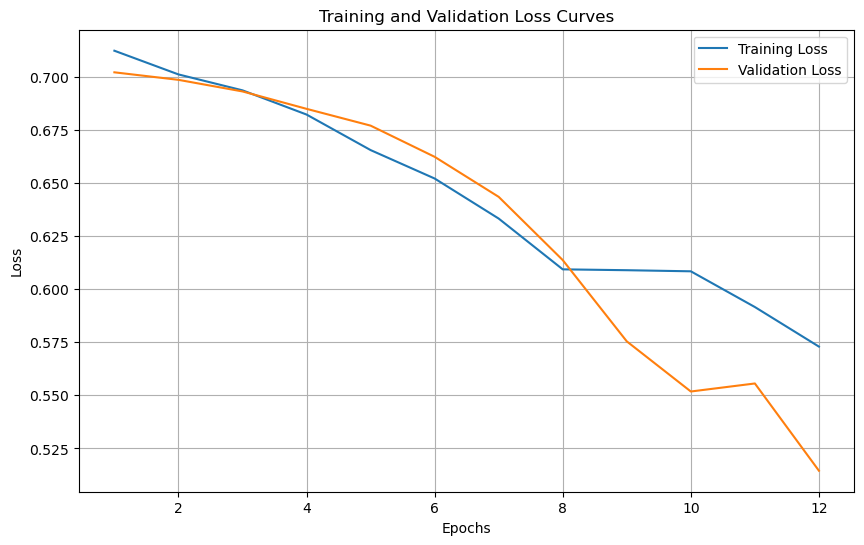

Test Accuracy: 0.8159
auc: 0.822, acc:0.816


In [ ]:
# show training and validation curves
def plot_loss_curves(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage:
plot_loss_curves(loss_values, val_loss_values)

# test
auc, acc = test(test_loader,model)

print(f'auc: {round(float(auc),3)}, acc:{round(float(acc),3)}')

# What are the strengths and weaknesses of classification models?
### In the previous tasks, you worked on CNN and 3D CNN. What are other networks that can realize image classification? (Please make at least 3 examples.) Could you discuss the pros and cons of CNNs and the networks you listed in medical image classification?

Residual Networks(ResNet),Inception Networks(GoogleNet) and Xception are some of the examples of advanced classification networks. Each of them has its own advantages and disadvantages as simple CNNs(like we use) have.

First of all, our CNN network has issue with reaching low loss values, not perfect accuracies with slight overfitting issue. Only advantage of our model is simplicity and size of it compare to the advanced networks, resulting less training and processing times.

For ResNet, skip connections of it helps to overcome vanishing gradient problem of huge networks have. Also, skip connection approach leads to faster convergence, and make the network more capable of finding fine details on dedicated image problem. On the other hand, it has more computational cost as expected since it is a large model to evaluate. Other than that, overfitting issue can be observed for respectively smaller datasets.

For Inception Networks, parallel convolutional nature of the network make it more verstatile for recognize patterns of various sizes. In other words,it can handle information(in this case images) at different scales. Disadvantages is this network is that memory consumtion is of course very large since the network is large. Also, it has huge training times as it has parralel nature.

For Xception, it is an improved version of Inception network but it has depthwise separable convolution structure results as less computational complexity(due to the less number of parameters) and better performance. It still  has high computational cost compare the simple CNN models but better than previous inception model. Additionally, this network offers less interpretbility since it has a complex structer making harder to decision-making process.